#### Вспомогательные либы

In [1]:
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from collections import Counter
import glob
import pickle
import keras
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Постановка задачи

Мы выбрали задачу предсказывания персонажей из мультсериала **Симпсоны**. Набор данных содержит **18 классов / персонажей** (данные по Kaggle содержат 20 классов, но в настоящее время мы использовали только 18 персонажений для обучения). Изображения имеют различный размер и в основном извлечены из эпизодов (сезон 4-24).

In [2]:
map_characters = {
    0: 'abraham_grampa_simpson',
    1: 'apu_nahasapeemapetilon', 
    2: 'bart_simpson', 
    3: 'charles_montgomery_burns', 
    4: 'chief_wiggum', 
    5: 'comic_book_guy', 
    6: 'edna_krabappel', 
    7: 'homer_simpson', 
    8: 'kent_brockman', 
    9: 'krusty_the_clown', 
    10: 'lisa_simpson', 
    11: 'marge_simpson', 
    12: 'milhouse_van_houten', 
    13: 'moe_szyslak', 
    14: 'ned_flanders', 
    15: 'nelson_muntz', 
    16: 'principal_skinner', 
    17: 'sideshow_bob'
}

Картинки имеют формат BGR и разный размер. Поэтому приведет все картинки к фиксированному размеру и к формату RGB. Сразу картинки не будем загружать в память, во избежания переполнения памяти в оперативке. Загружать будем во время батча для тренировки или предсказания

In [3]:
def show_image_from_path(ax, x, y):
    y = map_characters[y]
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    ax.imshow(img)
    ax.text(2, 58, '{}'.format(y), fontsize=12, bbox={'facecolor': 'white', 'pad': 2})

def show_image(ax, image, label):
    ax.imshow(image)
    ax.text(2, 58, '{}'.format(map_characters[label]), fontsize=12, bbox={'facecolor': 'white', 'pad': 2}) 
    
def show_image_with_dict(ax, image, l):
    ax.imshow(image)
    labels = ['{}: {:.2f}'.format(label, value) for label, value in l]
    text = '\n'.join(labels)
    ax.text(2, 58, text, fontsize=9, bbox={'facecolor': 'white', 'pad': 2})
    
def print_example(X,Y):
    f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        show_image_from_path(ax, X[i], Y[i])

In [4]:
def collect_train_paths(images_dir = 'simpsons_dataset/'):
    np.random.seed(42)
    x_path_train = []
    y_train = []
    for key, value in map_characters.items():
        person_images_path = os.listdir(os.path.join(images_dir, value))
        person_images_path.sort()
        x_path_train.extend(list(map(lambda x: os.path.join(images_dir, value, x), person_images_path)))
        y_train.extend([key]*len(person_images_path))

    x_path_train = np.array(x_path_train)
    y_train = np.array(y_train)

    indices = np.arange(x_path_train.shape[0])
    np.random.shuffle(indices)
    x_path_train = x_path_train.take(indices, axis=0)
    y_train = y_train.take(indices, axis=0)
        
    return x_path_train, y_train

In [5]:
def collect_test_paths(images_dir = 'kaggle_simpson_testset/kaggle_simpson_testset'):
    np.random.seed(42)
    x_test_path = []
    y_test = []
    for image_name in os.listdir(images_dir):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label, character in map_characters.items() if character == character_name][0]
        x_test_path.append(os.path.join(images_dir, image_name))
        y_test.append(label)
    
    x_test_path = np.array(x_test_path)
    y_test = np.array(y_test)
    indices = np.arange(x_test_path.shape[0])
    np.random.shuffle(indices)
    x_test_path = x_test_path.take(indices, axis=0)
    y_test = y_test.take(indices, axis=0)
    
    return np.array(x_test_path), np.array(y_test)

Получаем пошафленную тренировочную выборку в виде путей. (Сразу загрузгу не делаем картинок)

In [6]:
x_train_paths, y_train = collect_train_paths('simpsons/simpsons_dataset')

### Тренировочные и тестовые наборы данных.

Тренировочная выборка включает в себя около **1000 изображений на каждого персонажа**. Персонаж не обязательно центрируется на каждом изображении и иногда может быть с другими персонажами (но это должно быть самой важной частью на картинке).

Отобразим несколько картинок тренировочной выборки

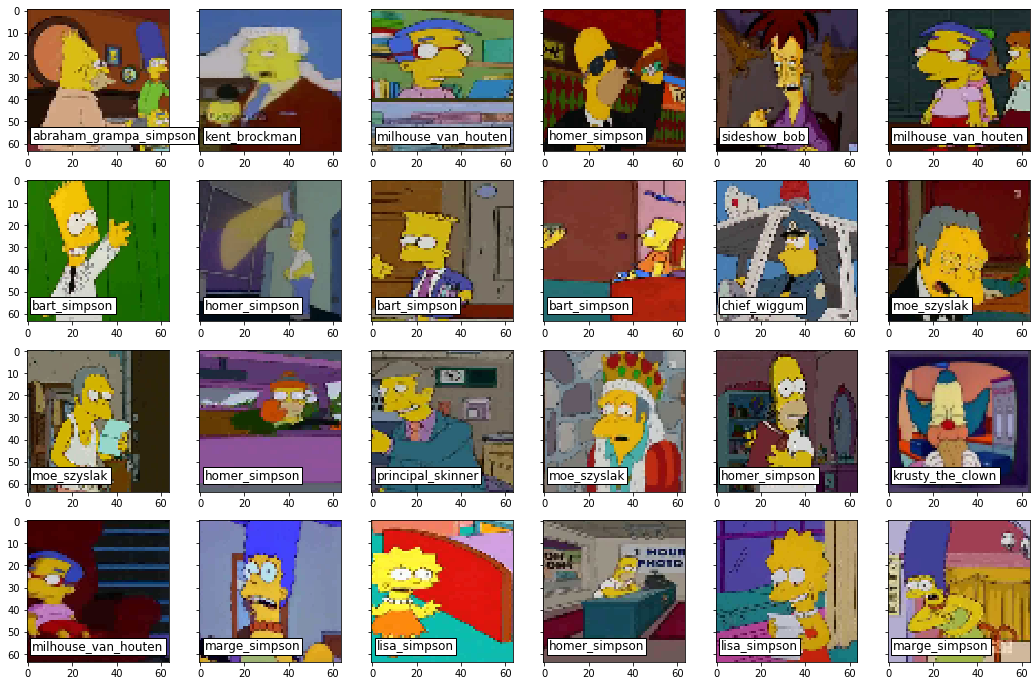

In [7]:
f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
for i, ax in enumerate(axes.flat):
    show_image_from_path(ax, x_train_paths[i], y_train[i]) 

Функции для выдерания батч путей картинок и неспосредственно загрузка батч картинок

In [8]:
def load_from_paths(x_path_batch, img_size=64):
    batches = np.empty((len(x_path_batch), img_size, img_size, 3))

    for i, x_path_i in enumerate(x_path_batch):
        img = cv2.imread(x_path_i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.
        assert img.min() >= 0.0 and img.max() <= 1.0
        batches[i] = img
    return batches

def load_from_paths_batch(x_path, y, batch_size, img_size=64):
    SEED = 42
    np.random.seed(SEED)
    
    n_batch = len(x_path) // batch_size
    while (True):
        indices = np.arange(x_path.shape[0])
        np.random.shuffle(indices)
        x_path_take = x_path.take(indices, axis=0)
        y_take = y.take(indices, axis=0)

        for i in range(0, len(x_path), batch_size):
            x_path_batch = x_path_take[i : i + batch_size]
            y_batch = y_take[i : i + batch_size]
            batches = load_from_paths(x_path_batch, img_size)
            yield (batches, y_batch)

Проверим, что они корректно работают:

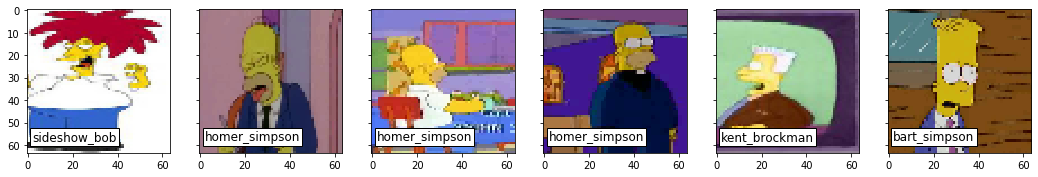

In [9]:
n_image = 6
gen = load_from_paths_batch(x_train_paths, y_train, n_image)
(im, index) = gen.__next__()
f, axes = plt.subplots(1, n_image, sharey=True, figsize=(3*n_image, 3))
for i, ax in enumerate(axes):
    show_image(ax, im[i], index[i])

Валидироваться будем на валидационном датасете, который выделим из тренировочного.

Тестовая выборка состоит из 50 картнинок на каждого персонажа. Но использовать тестовые данные будем **только на финальной модели** в каждой лабораторной.

Методы для тренировки и тестирования наших моделей:

In [10]:
def train_model(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    generator = load_from_paths_batch(X_train, Y_train, batch_size, img_size)
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model
    
def test_model(model, x_test, img_size=64):
    x_test = load_from_paths(x_test)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, 1)
    return y_pred

### ЛР4. Применение переноса обучения для решения задачи

### I способ. Подставляем архитектуру. Настраиваем с нуля.

In [189]:
from keras_vggface.vggface import VGGFace
from keras import optimizers

vgg_model = VGGFace(include_top=True, weights=None, model='vgg16',
                    input_shape=(224, 224, 3), classes=18)

vgg_model = build_vgg()

sgd = optimizers.SGD(lr=0.01, momentum=0.9)
vgg_model.compile(
    optimizer="adam", 
    loss=keras.losses.sparse_categorical_crossentropy, 
    metrics=[keras.metrics.sparse_categorical_accuracy]
)

In [190]:
%%time
train_model(vgg_model, x_train_paths, y_train, x_test_paths, y_test,
            epoch=20, batch_size=512, img_size=224, verbose=1)

Epoch 1/20
38/38 [==============================] - 244s 6s/step - loss: 5.4729 - sparse_categorical_accuracy: 0.1073 - val_loss: 2.9491 - val_sparse_categorical_accuracy: 0.0562
Epoch 2/20
38/38 [==============================] - 233s 6s/step - loss: 2.7188 - sparse_categorical_accuracy: 0.1345 - val_loss: 3.0784 - val_sparse_categorical_accuracy: 0.1112
Epoch 3/20
38/38 [==============================] - 231s 6s/step - loss: 2.4676 - sparse_categorical_accuracy: 0.2157 - val_loss: 3.4768 - val_sparse_categorical_accuracy: 0.1303
Epoch 4/20
38/38 [==============================] - 234s 6s/step - loss: 2.2643 - sparse_categorical_accuracy: 0.2740 - val_loss: 2.4884 - val_sparse_categorical_accuracy: 0.2236
Epoch 5/20
38/38 [==============================] - 235s 6s/step - loss: 1.8791 - sparse_categorical_accuracy: 0.3927 - val_loss: 2.2494 - val_sparse_categorical_accuracy: 0.3506
Epoch 6/20
38/38 [==============================] - 232s 6s/step - loss: 1.6270 - sparse_categorical_accu

'Аккураси на тестовой выборки: 0.9752808988764045'

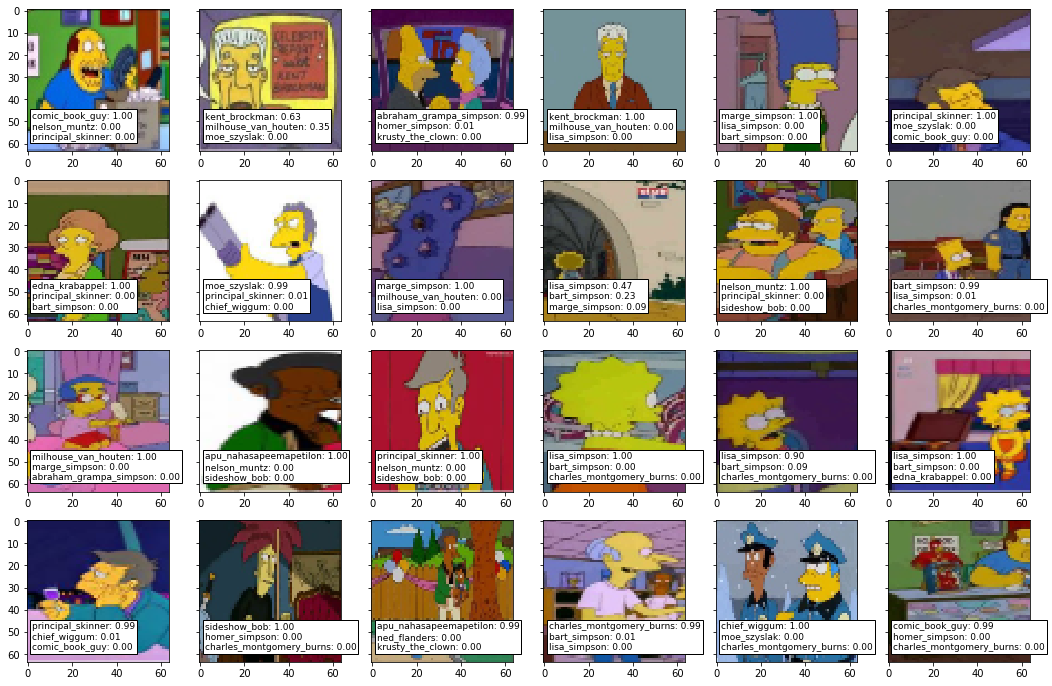

In [192]:
x_test = load_from_paths(x_test_paths, img_size=224)
y_pred = vgg_model.predict(x_test)

visualize_results(x_test, y_pred)
y_pred = np.argmax(y_pred, 1)

"Аккураси на тестовой выборки: {}".format((y_test == y_pred).mean())

### II способ. Берем обученное признаковое пространство. Используем свой классификатор.

In [78]:
from keras_vggface.vggface import VGGFace
vgg_features = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [80]:
from keras_vggface import utils

def features_from_intermedia_layer(model_features, x_path, batch_size = 512):
    n_batch = len(x_path) // batch_size + 1
    x_path_batches = np.array_split(x_path, n_batch)
    
    feature_array = []
    for x_path_batch in tqdm(x_path_batches):
        batches = np.empty((len(x_path_batch), 224, 224, 3))
        for i, x_path_i in enumerate(x_path_batch):
            img = cv2.imread(x_path_i)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            batches[i] = img
        img_preprocessed = utils.preprocess_input(batches, version=1)
        predict_features = model_features.predict(img_preprocessed)
        feature_array.append(predict_features)
    x_data = np.concatenate(feature_array)
    return x_data

In [81]:
%%time
x_train_features = features_from_intermedia_layer(vgg_features, x_train_paths, batch_size = 2048)
x_test_features = features_from_intermedia_layer(vgg_features, x_test_paths, batch_size = 2048)
x_train_features.shape, x_test_features.shape

100%|██████████| 1/1 [00:22<00:00, 22.53s/it]

CPU times: user 2h 44min 11s, sys: 16min 52s, total: 3h 1min 4s
Wall time: 8min 42s


((18992, 512), (890, 512))

In [124]:
from sklearn.linear_model import LogisticRegression

In [125]:
%%time
clf = LogisticRegression(random_state=0, C=1e5, solver='lbfgs', multi_class='multinomial').fit(x_train_features, y_train)

CPU times: user 18.7 s, sys: 9.31 s, total: 28 s
Wall time: 2.41 s


In [126]:
y_pred = clf.predict_proba(x_test_features)

y_pred = np.argmax(y_pred, 1)

"Аккураси на тестовой выборки: {}".format((y_test == y_pred).mean())

'Аккураси на тестовой выборки: 0.6134831460674157'

In [129]:
import xgboost as xgb
xgtrain = xgb.DMatrix(x_train_features, label=y_train)
xgtest = xgb.DMatrix(x_test_features, label=y_test)

In [140]:
params = {
    "objective" :                  "multi:softprob", 
    'num_class':                    18,
    'eval_metric':                 "merror",
    "booster" :                    "gbtree",
    'eta':                          0.1, 
    'gamma':                        1.0,
    'min_child_weight':             0.1,
    'max_depth':                    6,
    'tree_method':                  'hist',
    'num_boost_round':              200,
}

In [141]:
%%time
xbm = xgb.train(params, xgtrain, num_boost_round=200, evals=[(xgtest, 'validation')], verbose_eval=False)

CPU times: user 53min 49s, sys: 37min 39s, total: 1h 31min 28s
Wall time: 7min 37s


In [149]:
y_pred_train = xbm.predict(xgtrain)
y_pred_train = np.argmax(y_pred_train, 1)
"Аккураси на тренировочной выборке: {}".format((y_train == y_pred_train).mean())

'Аккураси на тренировочной выборке: 1.0'

'Аккураси на тестовой выборки: 0.9404494382022472'

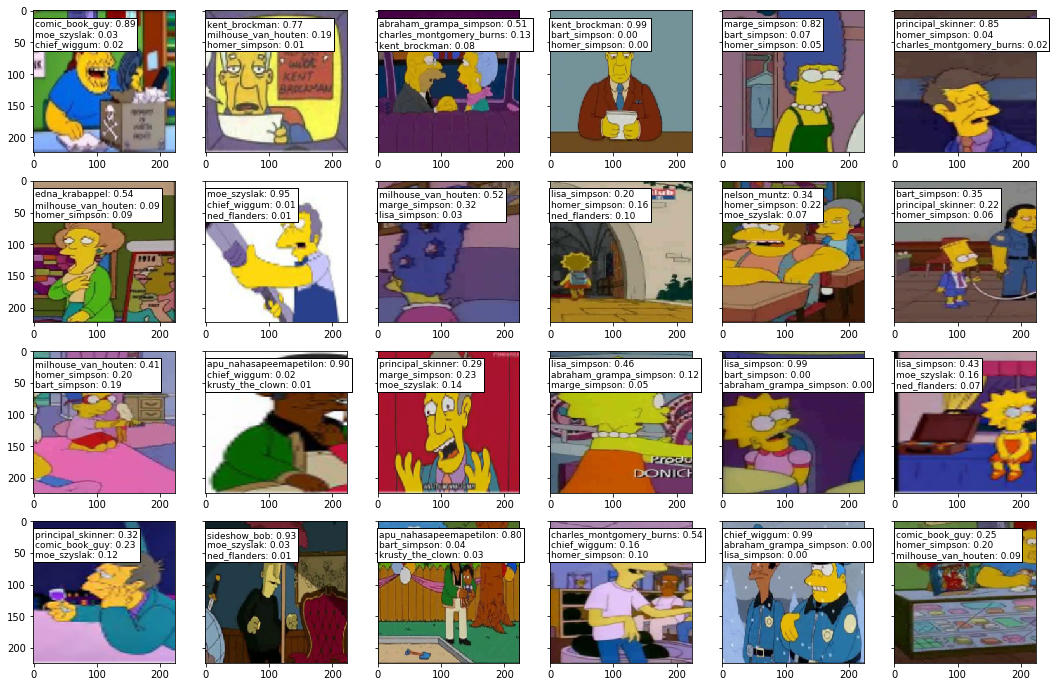

In [144]:
x_test = load_from_paths(x_test_paths, img_size=224)
y_pred = xbm.predict(xgtest)

visualize_results(x_test, y_pred)
y_pred = np.argmax(y_pred, 1)

"Аккураси на тестовой выборки: {}".format((y_test == y_pred).mean())

### III способ. Подставляем архитектуру c обыченными параметрами. Заменяем голову.

In [102]:
import keras.layers as L
from keras.models import Model
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
for layer in vgg_model.layers:
    layer.trainable = False
x = L.Flatten(name='flatten')(last_layer)
x = L.Dense(256, activation='relu', name='fc6')(x)
out = L.Dense(len(map_characters), activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)
custom_vgg_model.compile(
    optimizer="adam", 
    loss=keras.losses.sparse_categorical_crossentropy, 
    metrics=[keras.metrics.sparse_categorical_accuracy]
)

In [104]:
%%time
train_model(custom_vgg_model, x_train_paths, y_train, x_test_paths, y_test, 20, 512)

Epoch 1/20
38/38 [==============================] - 464s 12s/step - loss: 2.2167 - sparse_categorical_accuracy: 0.3661 - val_loss: 1.7714 - val_sparse_categorical_accuracy: 0.5449
Epoch 2/20
38/38 [==============================] - 450s 12s/step - loss: 1.3683 - sparse_categorical_accuracy: 0.6473 - val_loss: 1.2367 - val_sparse_categorical_accuracy: 0.6618
Epoch 3/20
38/38 [==============================] - 450s 12s/step - loss: 1.0032 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.9316 - val_sparse_categorical_accuracy: 0.7551
Epoch 4/20
38/38 [==============================] - 449s 12s/step - loss: 0.7738 - sparse_categorical_accuracy: 0.8162 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.8303
Epoch 5/20
38/38 [==============================] - 450s 12s/step - loss: 0.6087 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.5980 - val_sparse_categorical_accuracy: 0.8674
Epoch 6/20
38/38 [==============================] - 450s 12s/step - loss: 0.4869 - sparse_categorica

'Аккураси на тестовой выборки: 0.9977528089887641'

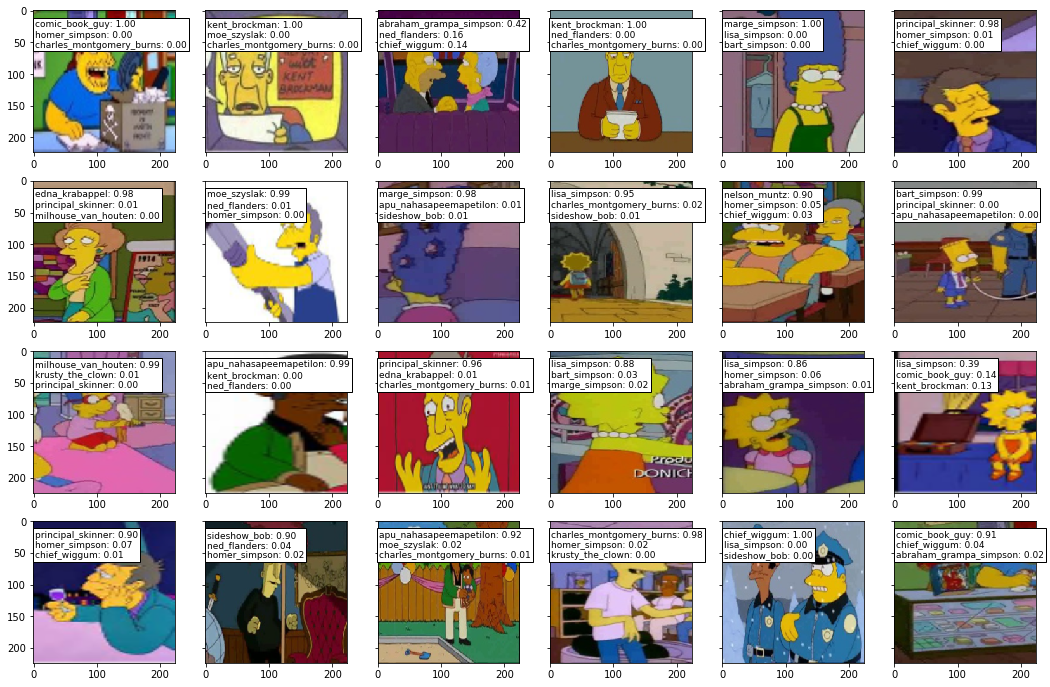

In [115]:
x_test = load_from_paths(x_test_paths, img_size=224)
y_pred = custom_vgg_model.predict(x_test)

visualize_results(x_test, y_pred)
y_pred = np.argmax(y_pred, 1)

"Аккураси на тестовой выборки: {}".format((y_test == y_pred).mean())